In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import model_based_agent as mba 
import worm_env as we 
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

# HT correction testing 

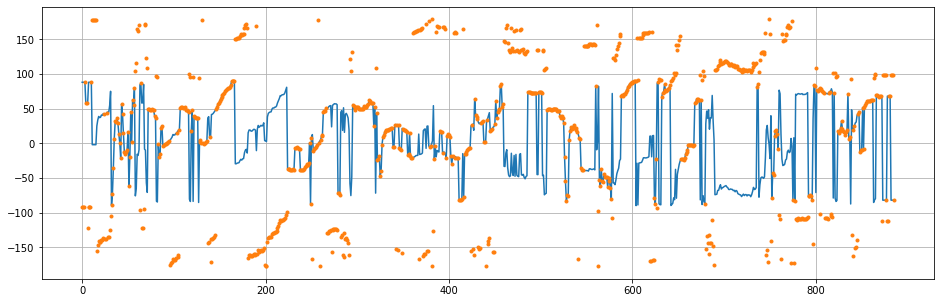

In [131]:
# Demo of working HT correction
tmp=350
plt.figure(figsize=(16,5))
plt.plot(ad)
plt.plot(od,'.')
plt.grid();

In [136]:
df = make_df_HT('./Data/HTDeb18-01-20-45/collect0.pkl')

<ipython-input-116-efe45648eab3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['angs'][i] = np.flip(df['angs'][i])


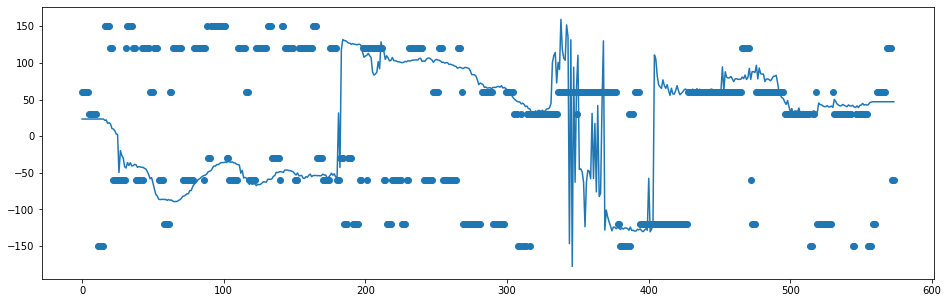

In [124]:
# Without correction
plt.figure(figsize=(16,5))
plt.scatter(np.arange(len(df)),df['obs_b'].to_numpy())
plt.plot(angs)

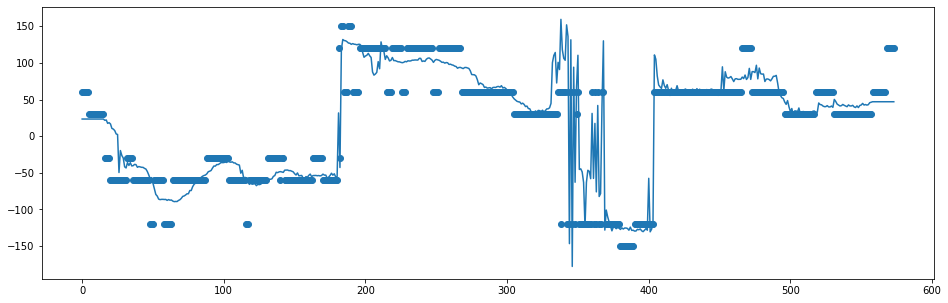

In [121]:
# With correction
plt.figure(figsize=(16,5))
plt.scatter(np.arange(len(df)),df['obs_b'].to_numpy())
plt.plot(angs)

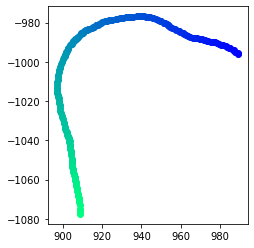

In [34]:
NPOINTS = 200
start = 0
fig,ax = plt.subplots(1)

ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in np.arange(start,start+NPOINTS-1):
    img = ax.scatter(locs[i,0],-locs[i,1])
    ax.set_aspect('equal','box')

# Continuity checks

#### Save some trajectories with all the modifications (include both angles, include target in traj)

In [60]:
frac_on = 1/2
collection_ep_time = 300 # in seconds. Must be a multiple of worm_ep_len
worm_ep_len = 300 # in seconds

folder = './Data/HTFix'+datetime.now().strftime('%d-%m-%H-%M')+'/'
if os.path.isdir(folder):
    os.rmdir(folder)
os.mkdir(folder)

# Initialize objects
worm = we.ProcessedWorm(0,ep_len=worm_ep_len) 

for ce in range(6):
# Collecting random data
#############################
    fname = folder+f'collect{ce}.pkl'
    mba.get_init_traj(fname, worm, int(collection_ep_time/worm_ep_len), rand_probs=[1-frac_on,frac_on])

C:\Users\ccli3\Documents\Research\20_09_07_NewPC\RLWorms\01_13_reals\improc.py:196: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


#### Process trajs and join them in a df after HT correction

In [70]:
folder = './Data/HTFix19-01-21-18/'
dfs = []
for i in range(3):
    fname = folder+f'collect{i}.pkl'
    angs,new_df = ut.make_df_HT(fname)
    dfs.append(new_df)
dfs = pd.concat(dfs)

In [71]:
dfs.to_pickle(folder+'alls.pkl')
params = {
    'reward_ahead': 10,
    'timestep_gap': 1,
    'prev_act_window': 3,
    'jump_limit': 100,
}
with open(folder+'alls_params.pkl','wb') as f:
    pickle.dump(params,f)

In [80]:
folder1 = './Data/HTFix19-01-18-47/'
folder2 = './Data/HTFix19-01-20-29/'
folder3 = './Data/HTFix19-01-21-18/'

dh = mba.DataHandler()
dh.load_df(folder1+'alls.pkl')
dh.add_df_to_df([folder2+'alls.pkl'])
#dh.add_df_to_df([folder3+'alls.pkl'])

In [81]:
dh.df

,t,obs_b,angs,prev_actions,reward,loc,target,obs_h,next_obs_b,next_obs_h
0,0.984,-30,"[90, 270]",3,6.421441,"[1007.8554216867469, 1002.0602409638554]",90,30.0,-30.0,30.0
1,1.172,-30,"[90, 270]",2,6.134315,"[1008.2528735632184, 1000.9195402298851]",90,30.0,-30.0,30.0
2,1.375,-30,"[90, 270]",1,6.425035,"[1008.3827160493827, 1000.469135802469]",90,30.0,-30.0,30.0
3,1.562,-30,"[90, 240]",0,6.587415,"[1008.6585365853659, 999.7317073170732]",90,30.0,-30.0,30.0
4,1.765,-30,"[90, 240]",0,6.356707,"[1008.6470588235295, 999.3764705882354]",90,30.0,-30.0,60.0
...,...,...,...,...,...,...,...,...,...,...
17787,297.718,-60,"[90, 0]",0,-1.745722,"[323.7368421052632, 1108.2280701754387]",180,-30.0,-60.0,-30.0
17788,297.906,-60,"[90, 240]",1,-0.743158,"[324.2769230769231, 1108.4307692307693]",180,-30.0,-60.0,-30.0
17789,298.093,-60,"[90, 180]",2,-1.105430,"[324.15492957746477, 1108.1267605633802]",180,-30.0,-60.0,-60.0
17790,298.281,-60,"[60, 300]",3,-1.826552,"[324.2258064516129, 1108.225806451613]",180,-60.0,-60.0,-30.0


In [82]:
mset = eme.ModelSet(1,frac=1,lp_frac=.4)
mset.make_models(dh,sm_pars={'lambda':.1,'iters':10})

On model 0
Penalty -0.004491099987974145


#### See how models look after processing

In [78]:
def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on'][:,:,0]-mod['reward_off'][:,:,0]),vmin=-1,vmax=1)

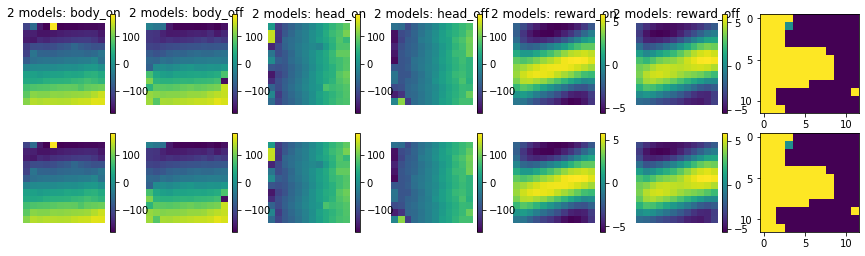

In [83]:
mod = mset.models[0]
mods_plt = [mod,mod]
plot_mods(mods_plt)

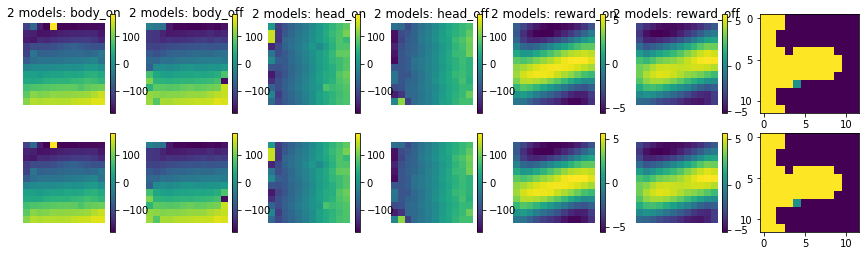

In [79]:
mod = mset.models[0]
mods_plt = [mod,mod]
plot_mods(mods_plt)